In [1]:
%run ../src/start.py


python	3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
---------------------
Versions:
----------------------
pandas      1.1.2
numpy       1.19.1
matplotlib  3.3.1
seaborn     0.11.0
plotly      4.11.0
boto3       1.17.106
awswrangler 2.9.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
HERE_DIR: list current directory path
RAW_DIR: list files in `data\raw` directory
INTER_DIR: list files in `data\interim` directory
FINAL_DIR: list files in `data\final` directory
SRC_DIR: list files in `src\` directory
------------------------------

# SAVE PLOTS
To save a plot 

## Load Data

In [2]:
# year file
year = '2010'

In [3]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [4]:
raw = bucket_raw_path('salas-data',f'capstone/raw-data/crime-data/{year}')
raw

's3://salas-data/capstone/raw-data/crime-data/2010'

## List objects in bucket

In [5]:
wr.s3.list_objects(raw)

['s3://salas-data/capstone/raw-data/crime-data/2010/apr10.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2010/aug10.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2010/dec10.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2010/feb10.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2010/jan10.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2010/jul10.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2010/jun10.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2010/mar10.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2010/may10.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2010/nov10.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2010/oct10.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2010/sep10.xlsx']

## Create dataframe from s3 files

In [6]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i, engine='openpyxl')
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [8]:
%%time
df = s3_files_to_df(raw)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136262 entries, 0 to 136261
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           136262 non-null  datetime64[ns]
 1   Hour           136262 non-null  int64         
 2   Offense Type   136262 non-null  object        
 3   Beat           136262 non-null  object        
 4   Premise        136262 non-null  object        
 5   Block Range    136262 non-null  object        
 6   Street Name    136262 non-null  object        
 7   Type           136262 non-null  object        
 8   Suffix         136262 non-null  object        
 9   . Of Offenses  124555 non-null  float64       
 10  . of Offenses  11707 non-null   float64       
 11  Field11        0 non-null       float64       
 12  Field12        0 non-null       float64       
 13  Field13        0 non-null       float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(7

In [ ]:
## cleanup columns
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [ ]:
df.info()

In [ ]:
df.head()

## Show null data

In [9]:
df.apply(lambda x: sum(x.isnull()))

Date                  0
Hour                  0
Offense Type          0
Beat                  0
Premise               0
Block Range           0
Street Name           0
Type                  0
Suffix                0
. Of Offenses     11707
. of Offenses    124555
Field11          136262
Field12          136262
Field13          136262
dtype: int64

In [10]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
. Of Offenses,8.59
Date,0.00
Hour,0.00
Offense Type,0.00
Beat,0.00
Premise,0.00
Block Range,0.00
Street Name,0.00
Type,0.00
Suffix,0.00


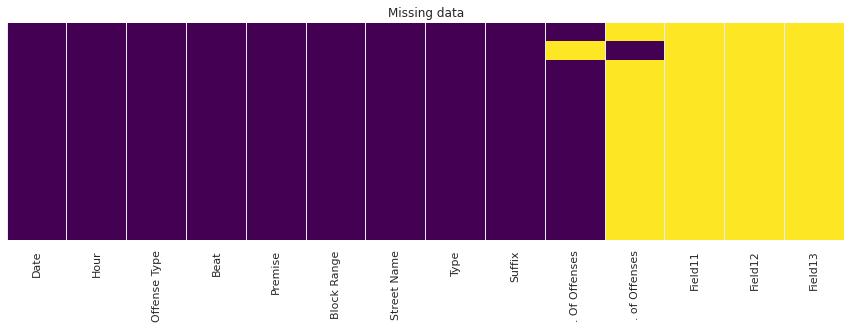

In [11]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Combine Coluumns

In [12]:
# combine columns into a new one
df['offenses'] = pd.concat([df['. Of Offenses'].dropna(),
                              df['. of Offenses'].dropna()]).reindex_like(df)

# drop columns
df = df.drop(['. Of Offenses','. of Offenses', 'Field11',
 'Field12',
 'Field13'], axis = 1)

In [13]:
## cleanup columns
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [14]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
block_range     0
street_name     0
type            0
suffix          0
offenses        0
dtype: int64

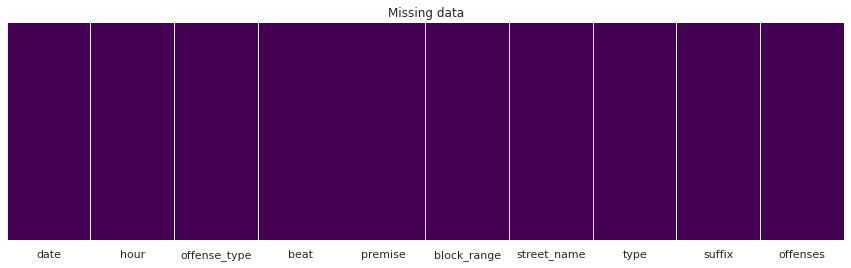

In [15]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Combine columns 

## Combine date & hour to one column

In [16]:
# convert two columns into one datetime
df['date_time'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# drop columns
df = df.drop(['date','hour'], axis = 1)

In [ ]:
# combine columns into a new one
df['offenses'] = pd.concat([df['#_of_offenses'].dropna(),
                              df['._of_offenses'].dropna()]).reindex_like(df)

# drop columns
df = df.drop(['#_of_offenses','._of_offenses'], axis = 1)

In [ ]:
df.apply(lambda x: sum(x.isnull()))

In [ ]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136262 entries, 0 to 136261
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  136262 non-null  object        
 1   beat          136262 non-null  object        
 2   premise       136262 non-null  object        
 3   block_range   136262 non-null  object        
 4   street_name   136262 non-null  object        
 5   type          136262 non-null  object        
 6   suffix        136262 non-null  object        
 7   offenses      136262 non-null  float64       
 8   date_time     136262 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 9.4+ MB


In [18]:
df.head()

,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time
0,Murder,13D20,05W,6600-6699,HEFFERNAN,-,-,1.0,2010-04-17 00:00:00
1,Murder,11H40,20R,10100-10199,LUCORE,-,-,1.0,2010-04-08 20:00:00
2,Murder,19G20,13R,11400-11499,CARVEL,LN,-,2.0,2010-04-01 22:00:00
3,Murder,10H60,13R,3700-3799,WHEELER,-,-,1.0,2010-04-17 01:00:00
4,Murder,14D30,20R,5100-5199,MYRTLEWOOD,DR,-,1.0,2010-04-08 23:00:00


## Convert offenses to integer

In [19]:
# convert offenses to int
df['offenses'] = df['offenses'].astype('int64')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136262 entries, 0 to 136261
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  136262 non-null  object        
 1   beat          136262 non-null  object        
 2   premise       136262 non-null  object        
 3   block_range   136262 non-null  object        
 4   street_name   136262 non-null  object        
 5   type          136262 non-null  object        
 6   suffix        136262 non-null  object        
 7   offenses      136262 non-null  int64         
 8   date_time     136262 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 9.4+ MB


## change order of columns

In [21]:
col_ord =['date_time','offenses','offense_type', 'block_range', 'street_name', 'type', 'suffix','beat', 'premise']
df = df[col_ord]
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2010-04-17 00:00:00,1,Murder,6600-6699,HEFFERNAN,-,-,13D20,05W
1,2010-04-08 20:00:00,1,Murder,10100-10199,LUCORE,-,-,11H40,20R
2,2010-04-01 22:00:00,2,Murder,11400-11499,CARVEL,LN,-,19G20,13R
3,2010-04-17 01:00:00,1,Murder,3700-3799,WHEELER,-,-,10H60,13R
4,2010-04-08 23:00:00,1,Murder,5100-5199,MYRTLEWOOD,DR,-,14D30,20R


## Save to bucket

In [22]:
bucket = 'salas-data'
file_name = 'crime_2010.csv'
path_to_save = f"s3://{bucket}/capstone/inter-data/crime-data/{file_name}"
path_to_save

's3://salas-data/capstone/inter-data/crime-data/crime_2010.csv'

In [23]:
%%time
wr.s3.to_csv(df, path_to_save, index=False)

CPU times: user 484 ms, sys: 109 ms, total: 594 ms
Wall time: 6.57 s


{'paths': ['s3://salas-data/capstone/inter-data/crime-data/crime_2010.csv'],
 'partitions_values': {}}